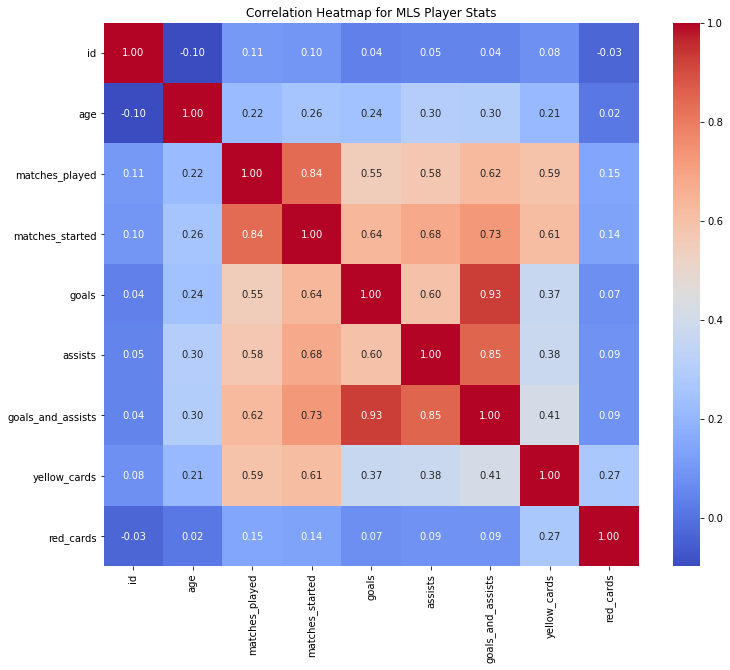


Top 3 predictors for 'goals':
matches_started    0.635872
matches_played     0.546690
yellow_cards       0.366114
Name: goals, dtype: float64


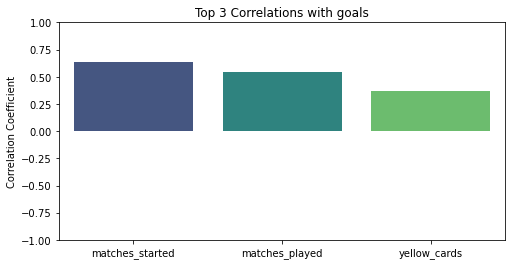


Top 3 predictors for 'assists':
matches_started    0.680775
matches_played     0.575767
yellow_cards       0.375566
Name: assists, dtype: float64


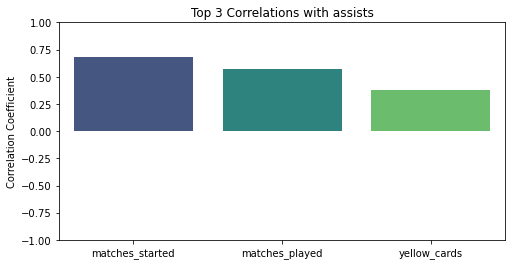


Top 3 predictors for 'goals_and_assists':
matches_started    0.729792
matches_played     0.623010
yellow_cards       0.412568
Name: goals_and_assists, dtype: float64


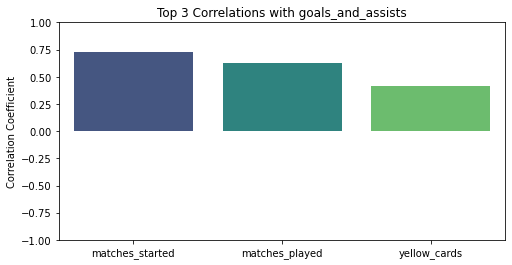

Trained model for 'goals' using predictors: ['matches_started', 'matches_played', 'yellow_cards']
Trained model for 'assists' using predictors: ['score_goals', 'matches_started', 'matches_played']
Trained model for 'goals_and_assists' using predictors: ['score_goals', 'score_assists', 'matches_started']

DataFrame with player scores:
    player_score  score_goals  score_assists  score_goals_and_assists
0       5.693690     4.911270       3.629264                 8.540534
1       0.035060     0.094414      -0.041825                 0.052589
6       0.229984     0.322883       0.022092                 0.344975
9       1.164471     1.123092       0.623614                 1.746707
10      0.473876     0.495439       0.215374                 0.710813
Club-level DataFrame (first few rows):
           club  overall_attacking_score  num_players
0   Atlanta Utd                 2.753376           10
1        Austin                 4.108753            6
2   CF Montréal                 2.292844   

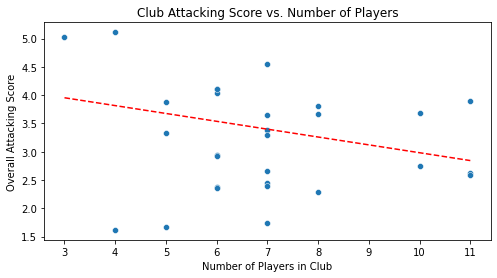

Merged DataFrame (first few rows):
              club  overall_attacking_score  num_players   w   l   t   g  ga
0      Atlanta Utd                 2.753376           10  10  14  10  45  49
1           Austin                 4.108753            6  11  14   9  39  48
2        Charlotte                 1.744240            7  14  11   9  45  37
3     Chicago Fire                 4.033502            6   7  18   9  40  62
4  Colorado Rapids                 3.879350            5  15  14   5  58  60

Correlation Analysis:
Correlation between Overall Attacking Score and Wins (w): -0.22151961506592824
Correlation between Overall Attacking Score and Losses (l): 0.2309634037840373


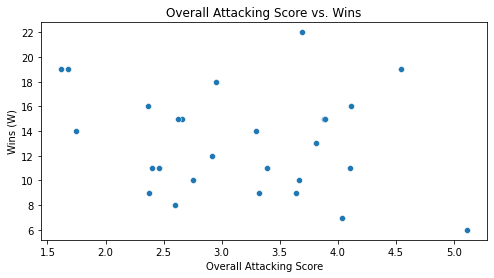

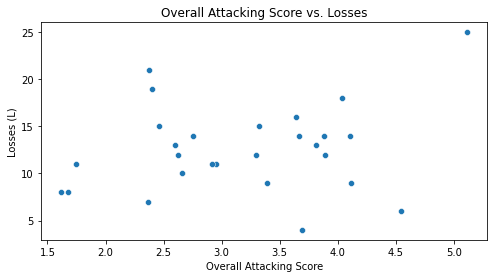


Regression Model for Wins:
Coefficient: -1.0247495033933336
Intercept: 16.36135656088276
R² Score: 0.04907093985895716
Mean Squared Error: 15.5905406403371

Regression Model for Losses:
Coefficient: 1.199893395701381
Intercept: 8.823872186786026
R² Score: 0.053344093887508603
Mean Squared Error: 19.574610601837723


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# file path 
file_path = 'Documents/2024 MLS Player Stats Database.csv'  

# CSV into a DataFrame
df = pd.read_csv(file_path)

# Remove unwanted columns such as text fields
columns_to_remove = ['name', 'country', 'born']
df = df.drop(columns=columns_to_remove)

# Removing defensive position players
df = df[~df['position'].isin(['Defender', 'Keeper'])]

# Drop rows with any missing values
df = df.dropna()

# -----------------------------------------------
# 2. Define a function to compute top 3 correlations
# -----------------------------------------------
def top3_correlations(df, target, exclude_cols):
    """
    Compute correlations for the target variable with all other columns,
    excluding the target itself and any columns specified in exclude_cols.
    Returns the top 3 predictors based on absolute correlation values.
    """
    # Select predictor columns (exclude target and specified columns)
    cols = [col for col in df.columns if col not in exclude_cols and col != target]
    # Compute correlation coefficients with the target variable
    correlations = df[[target] + cols].corr()[target].drop(target)
    # Sort by the absolute value of correlation and select the top 3
    top3 = correlations.reindex(correlations.abs().sort_values(ascending=False).index).head(3)
    return top3

# -----------------------------------------------
# 3. EDA Visualizations
# -----------------------------------------------

# 3.1. Correlation Heatmap for the entire dataset
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for MLS Player Stats")
plt.show()

# 3.2. Bar plots for top 3 predictors of each target variable

# Define target variables and their respective columns to exclude
targets = ['goals', 'assists', 'goals_and_assists']
exclude_mapping = {
    'goals': ['assists', 'goals_and_assists'],
    'assists': ['goals', 'goals_and_assists'],
    'goals_and_assists': ['goals', 'assists']
}

# Loop through each target variable and plot the top 3 correlations
for target in targets:
    top3 = top3_correlations(df, target, exclude_mapping[target])
    print(f"\nTop 3 predictors for '{target}':")
    print(top3)
    
    # Create a bar plot for the top 3 correlations
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top3.index, y=top3.values, palette="viridis")
    plt.title(f"Top 3 Correlations with {target}")
    plt.ylabel("Correlation Coefficient")
    plt.ylim(-1, 1)
    plt.show()
    
    
# -----------------------------------------------
# 4. Analysis: Model Building, Training, and Player Scoring
# -----------------------------------------------

# List of target variables (already defined earlier)
targets = ['goals', 'assists', 'goals_and_assists']
exclude_mapping = {
    'goals': ['assists', 'goals_and_assists'],
    'assists': ['goals', 'goals_and_assists'],
    'goals_and_assists': ['goals', 'assists']
}

score_columns = []

# For each target variable, build a linear regression model using the top 3 predictors
for target in targets:
    # Get the top 3 predictors using the function defined earlier
    top3 = top3_correlations(df, target, exclude_mapping[target])
    predictors = top3.index.tolist()
    
    # Create and train the linear regression model
    model = LinearRegression()
    X = df[predictors]
    y = df[target]
    model.fit(X, y)
    
    # Predict a score for each player using this model
    score_col = f'score_{target}'
    df[score_col] = model.predict(X)
    score_columns.append(score_col)
    
    # Display the predictors used for the model
    print(f"Trained model for '{target}' using predictors: {predictors}")

# Combine the predictions from all three models to create an overall player score.
# Here, we simply average the three scores.
df['player_score'] = df[score_columns].mean(axis=1)

# Display a sample of the DataFrame with the new score columns
print("\nDataFrame with player scores:")
print(df[['player_score'] + score_columns].head())

# -----------------------------------------------
# 5. Create Club-level DataFrame for Supervised Learning
# -----------------------------------------------
# Aggregate player-level scores into club-level overall attacking score.
# For each club, we compute:
#   - overall_attacking_score: the average player_score for the club.
#   - num_players: the number of players in the club.
df_club = df.groupby('club').agg(
    overall_attacking_score=('player_score', 'mean'),
    num_players=('player_score', 'count')
).reset_index()

print("Club-level DataFrame (first few rows):")
print(df_club.head())

# -----------------------------------------------
# Supervised Learning Problem: Predict Overall Attacking Score
# -----------------------------------------------
# In this simple example, we'll use 'num_players' as the feature to predict the club's overall attacking score.
X = df_club[['num_players']]
y = df_club['overall_attacking_score']

# Split the club-level data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the linear regression model
club_model = LinearRegression()
club_model.fit(X_train, y_train)

# Predict on the test set
y_pred = club_model.predict(X_test)

# Evaluate the model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("\nClub-level Model Performance:")
print("R² Score:", r2)
print("Mean Squared Error:", mse)

# -----------------------------------------------
# Visualization: Regression Results
# -----------------------------------------------
plt.figure(figsize=(8, 4))
sns.scatterplot(x=df_club['num_players'], y=df_club['overall_attacking_score'])
plt.xlabel("Number of Players in Club")
plt.ylabel("Overall Attacking Score")
plt.title("Club Attacking Score vs. Number of Players")

# Plot regression line
x_vals = np.linspace(df_club['num_players'].min(), df_club['num_players'].max(), 100)
y_vals = club_model.predict(x_vals.reshape(-1, 1))
plt.plot(x_vals, y_vals, 'r--')
plt.show()



# -----------------------------------------------
# 6. Analysis: Team Attacking Score vs. Wins and Losses
# -----------------------------------------------

# Load the team stats data from the new Excel file
file_path_team = 'Documents/MLS team stats updated.xlsx'
df_team = pd.read_excel(file_path_team)

# Standardize column names to lowercase so that 'Club' becomes 'club'
df_team.columns = df_team.columns.str.lower()

# Merge the club-level attacking score (df_club) with team stats on 'club'
df_merged = pd.merge(df_club, df_team, on='club', how='inner')
print("Merged DataFrame (first few rows):")
print(df_merged.head())

# --------------------------------------------------
# Correlation Analysis
# --------------------------------------------------
print("\nCorrelation Analysis:")
corr_w = df_merged['overall_attacking_score'].corr(df_merged['w'])
corr_l = df_merged['overall_attacking_score'].corr(df_merged['l'])
print("Correlation between Overall Attacking Score and Wins (w):", corr_w)
print("Correlation between Overall Attacking Score and Losses (l):", corr_l)

# --------------------------------------------------
# Scatter Plots
# --------------------------------------------------
# Scatter plot: Overall Attacking Score vs. Wins
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_merged, x='overall_attacking_score', y='w')
plt.xlabel("Overall Attacking Score")
plt.ylabel("Wins (W)")
plt.title("Overall Attacking Score vs. Wins")
plt.show()

# Scatter plot: Overall Attacking Score vs. Losses
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_merged, x='overall_attacking_score', y='l')
plt.xlabel("Overall Attacking Score")
plt.ylabel("Losses (L)")
plt.title("Overall Attacking Score vs. Losses")
plt.show()

# --------------------------------------------------
# Linear Regression Analysis for Wins
# --------------------------------------------------
model_w = LinearRegression()
X_w = df_merged[['overall_attacking_score']]
y_w = df_merged['w']
model_w.fit(X_w, y_w)
y_pred_w = model_w.predict(X_w)

print("\nRegression Model for Wins:")
print("Coefficient:", model_w.coef_[0])
print("Intercept:", model_w.intercept_)
print("R² Score:", r2_score(y_w, y_pred_w))
print("Mean Squared Error:", mean_squared_error(y_w, y_pred_w))

# --------------------------------------------------
# Linear Regression Analysis for Losses
# --------------------------------------------------
model_l = LinearRegression()
X_l = df_merged[['overall_attacking_score']]
y_l = df_merged['l']
model_l.fit(X_l, y_l)
y_pred_l = model_l.predict(X_l)

print("\nRegression Model for Losses:")
print("Coefficient:", model_l.coef_[0])
print("Intercept:", model_l.intercept_)
print("R² Score:", r2_score(y_l, y_pred_l))
print("Mean Squared Error:", mean_squared_error(y_l, y_pred_l))
